In [2]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from metpy.calc import moist_static_energy, saturation_mixing_ratio, specific_humidity_from_mixing_ratio, parcel_profile, dewpoint_from_specific_humidity, moist_lapse
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
# Load dataset
exp_name = 'convective_coupling/land/all_lat_strip'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

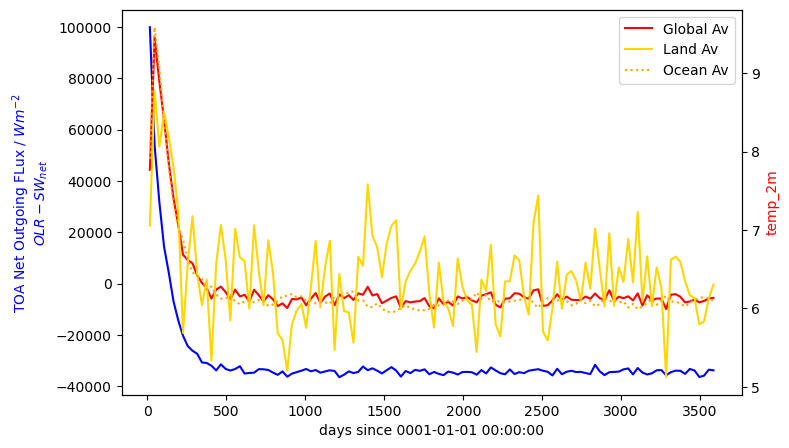

In [65]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(8, 5))
lat_land, lon_land = isca_tools.utils.land.get_land_coords(namelist['experiment_details']['input_dir']+'/namelist.nml')
lat_ocean, lon_ocean = isca_tools.utils.land.get_ocean_coords(namelist['experiment_details']['input_dir']+'/namelist.nml')
# Land is strip over all latitudes so land longitudes have no overlap with ocean
ds_land = ds.sel(lon=lon_land, method="nearest")
ds_ocean = ds.sel(lon=lon_ocean, method="nearest")
isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau)), ds.temp_2m, ax)
(isca_tools.utils.area_weighting(ds_land.temp_2m).mean(dim=['lon', 'lat'])- 273.15).plot(color='gold')
(isca_tools.utils.area_weighting(ds_ocean.temp_2m).mean(dim=['lon','lat'])- 273.15).plot(color='orange', linestyle=':')
# ax.set_xlim(0, 360*3);
plt.legend(['Global Av','Land Av', 'Ocean Av']);

## Moist static energy
Want to see whether moist static energy is conserved i.e. same at surface and in free troposphere for each latitude.

In [28]:
# Take time and zonal mean
# Use all data after 3 years, as clearly converged from the above spin up plot
ds_land_use = ds_land.sel(time=slice(360*3, np.inf)).mean(dim=['time', 'lon'])
ds_ocean_use = ds_ocean.sel(time=slice(360*3, np.inf)).mean(dim=['time', 'lon'])

In [29]:
# Get near surface moist static energy as function of latitude using 2m variables
mse_land_2m = moist_static_energy(2 * units.meters, ds_land_use.temp_2m * units.kelvin,
                                  ds_land_use.sphum_2m * units.kilogram/units.kilogram)
mse_ocean_2m = moist_static_energy(2 * units.meters, ds_ocean_use.temp_2m * units.kelvin,
                                  ds_ocean_use.sphum_2m * units.kilogram/units.kilogram)

In [31]:
# Sanity check to make sure that surface specific humidity is less than saturation specific humidity.
# I.e. check that saturation q calculation is correct
q_sat_land_2m = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_land_use.temp_2m * units.kelvin))
rh_land_2m = ds_land_use.sphum_2m / q_sat_land_2m
print("Land - Max Surface Relative Humidity: {:.3f}".format(rh_land_2m.to_numpy().max()))

q_sat_ocean_2m = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_ocean_use.temp_2m * units.kelvin))
rh_ocean_2m = ds_ocean_use.sphum_2m / q_sat_ocean_2m
print("Ocean - Max Surface Relative Humidity: {:.3f}".format(rh_ocean_2m.to_numpy().max()))

Land - Max Surface Relative Humidity: 0.935
Ocean - Max Surface Relative Humidity: 0.979


In [32]:
# Free troposphere MSE at 700hPa - units of pressure in dataset are hPa
pressure_ft = 700  # pressure level of free troposphere in hPa
ds_land_ft = ds_land_use.sel(pfull=pressure_ft, method='nearest')
q_sat_land_ft = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_land_ft.temp * units.kelvin))
mse_land_ft = moist_static_energy(ds_land_ft.height * units.meters, ds_land_ft.temp * units.kelvin,
                             q_sat_land_ft * units.kilogram/units.kilogram)

ds_ocean_ft = ds_ocean_use.sel(pfull=pressure_ft, method='nearest')
q_sat_ocean_ft = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_ocean_ft.temp * units.kelvin))
mse_ocean_ft = moist_static_energy(ds_ocean_ft.height * units.meters, ds_ocean_ft.temp * units.kelvin,
                             q_sat_ocean_ft * units.kilogram/units.kilogram)

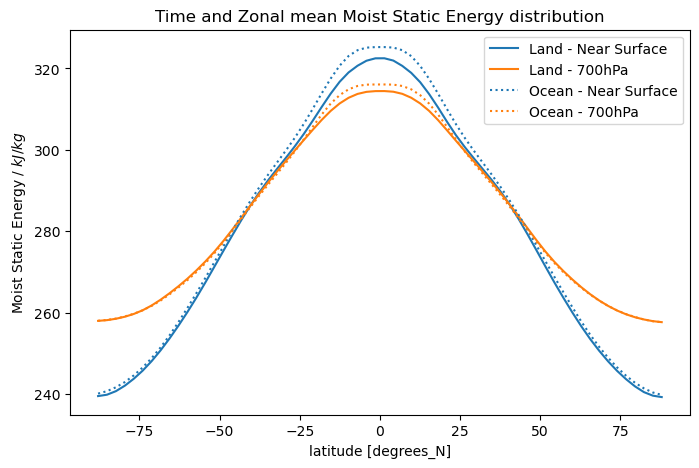

In [38]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_land_2m.plot.line(ax=ax, add_legend=False, label="Land - Near Surface", color=cmap(0))
mse_land_ft.plot.line(ax=ax, add_legend=False, label=f"Land - {pressure_ft}hPa", color=cmap(1))
mse_ocean_2m.plot.line(ax=ax, add_legend=False, label="Ocean - Near Surface", color=cmap(0), linestyle=':')
mse_ocean_ft.plot.line(ax=ax, add_legend=False, label=f"Ocean - {pressure_ft}hPa", color=cmap(1), linestyle=':')
ax.legend();
ax.set_ylabel('Moist Static Energy / $kJ/kg$');
ax.set_title('Time and Zonal mean Moist Static Energy distribution');

This plot shows that the moist static energy at the surface is not equal to the saturation moist static energy in the free troposphere, as we would expect if it was convectively coupled.

In [59]:
# Consider each latitude and pressure value and compute saturation MSE
q_sat_land_all = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_land_use.temp * units.kelvin))
mse_land_all = moist_static_energy(ds_land_use.height * units.meters, ds_land_use.temp * units.kelvin,
                             q_sat_land_all * units.kilogram/units.kilogram)
mse_land_all.name = 'saturation MSE';

q_sat_ocean_all = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_ocean_use.temp * units.kelvin))
mse_ocean_all = moist_static_energy(ds_ocean_use.height * units.meters, ds_ocean_use.temp * units.kelvin,
                             q_sat_ocean_all * units.kilogram/units.kilogram)
mse_ocean_all.name = 'saturation MSE';

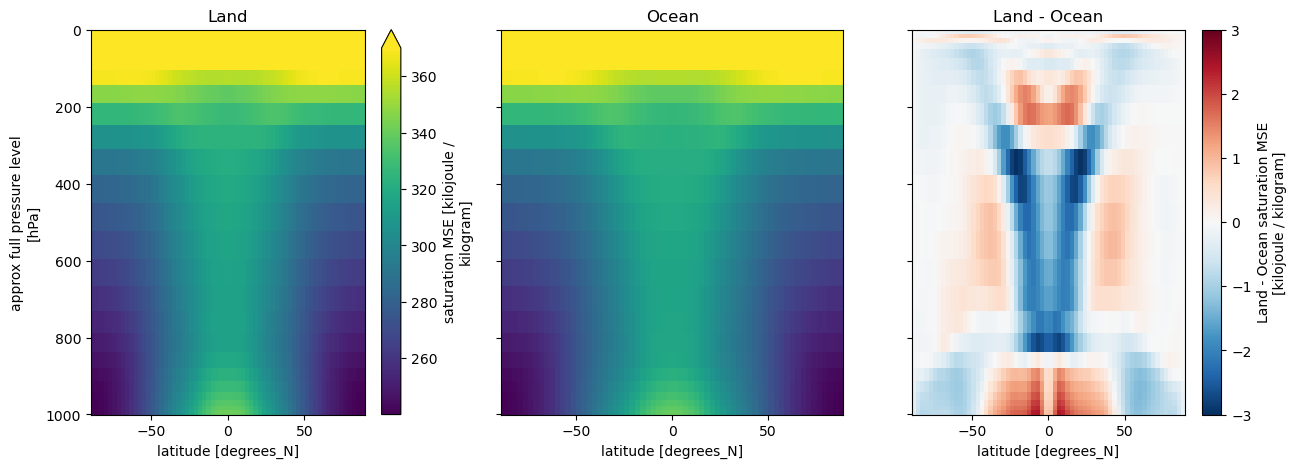

In [60]:
fig, axs = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
mse_land_all.plot(vmax=370, yincrease=False, ax=axs[0]);
mse_ocean_all.plot(vmax=370, yincrease=False, ax=axs[1], add_colorbar=False);
mse_diff_all = (mse_land_all-mse_ocean_all)
mse_diff_all.name = 'Land - Ocean saturation MSE'
mse_diff_all.plot(yincrease=False, ax=axs[2]);
axs[1].set_ylabel('');
axs[2].set_ylabel('');
axs[0].set_title('Land');
axs[1].set_title('Ocean');
axs[2].set_title('Land - Ocean');

From these plots, we see that the saturation MSE distribution over land and ocean are vertically identical.
This is likely to be because, to get this experiment to work, I had to raise the albedo to 0.4 (0.31 in d5 and seasonal experiments). This means that the MSE and temperatures are significantly smaller (average temperautre is $6\degree C$ as opposed to $13 \degree C$). So this world is less likely to be convectively active.

Another issue may be that there are no seasons, hence the lower heat capacity of land does not have any way to give an effect.

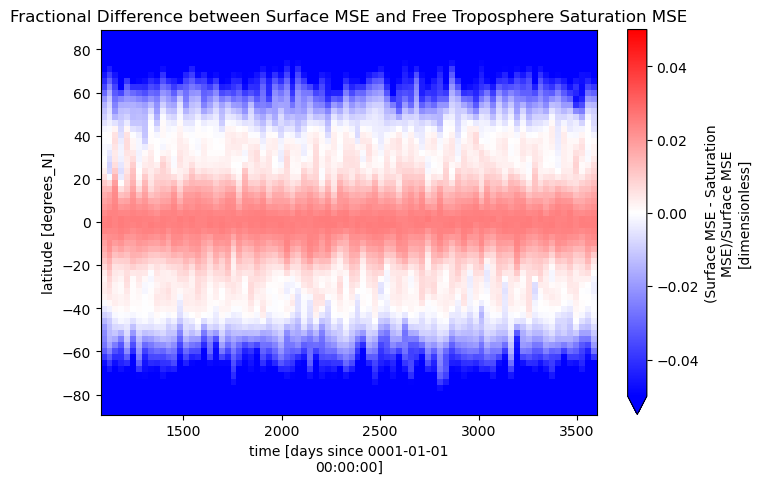

In [72]:
# Because from the spin up plot, we see that over land there is quite a large variance in temperature, below we plot
# how the MSE over land differs with time

ds_use = ds_land.sel(time=slice(360*3, np.inf)).mean(dim=['lon'])
# Get near surface moist static energy as function of latitude using 2m variables
mse_2m = moist_static_energy(2 * units.meters, ds_use.temp_2m * units.kelvin,
                             ds_use.sphum_2m * units.kilogram/units.kilogram)
# Free troposphere MSE at 700hPa - units of pressure in dataset are hPa
ds_ft = ds_use.sel(pfull=pressure_ft, method='nearest')
q_sat_ft = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_ft.temp * units.kelvin))
mse_ft = moist_static_energy(ds_ft.height * units.meters, ds_ft.temp * units.kelvin,
                             q_sat_ft * units.kilogram/units.kilogram)
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_diff = (mse_2m-mse_ft)/mse_2m
mse_diff.name = '(Surface MSE - Saturation MSE)/Surface MSE'
mse_diff.plot.pcolormesh(ax=ax, x='time', vmin=-0.05, vmax=0.05, cmap='bwr');
ax.set_title('Fractional Difference between Surface MSE and Free Troposphere Saturation MSE');